In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
spark = SparkSession.builder.config("spark.driver.memory","20g").getOrCreate()
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

In [3]:
dataset = spark.read.csv('tracks_features.csv',header= True)
dataset.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+-------------------+------------------+---+-------------------+----+--------------------+--------------------+--------------------+-------------------+-------------------+------------------+-----------+--------------+----+------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|       danceability|            energy|key|           loudness|mode|         speechiness|        acousticness|    instrumentalness|           liveness|            valence|             tempo|duration_ms|time_signature|year|release_date|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+-------------------+------------------+---+--

In [4]:
df = dataset.select('name', 'album', 'artists', 'explicit', 'energy', 'valence', 'tempo', 'duration_ms', 'time_signature', 'year')
cols = df.columns
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- album: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- explicit: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- tempo: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- time_signature: string (nullable = true)
 |-- year: string (nullable = true)



In [5]:
from pyspark.sql.types import StringType, FloatType, IntegerType, BooleanType

df = df.select(
    df.name.cast(StringType()),
    df.album.cast(StringType()),
    df.artists.cast(StringType()),
    df.explicit.cast(BooleanType()),
    df.energy.cast(FloatType()),
    df.valence.cast(FloatType()),
    df.tempo.cast(IntegerType()),
    df.duration_ms.cast(FloatType()),
    df.time_signature.cast(IntegerType()),
    df.year.cast(IntegerType()),
)

df.printSchema()
df.show()

root
 |-- name: string (nullable = true)
 |-- album: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- energy: float (nullable = true)
 |-- valence: float (nullable = true)
 |-- tempo: integer (nullable = true)
 |-- duration_ms: float (nullable = true)
 |-- time_signature: integer (nullable = true)
 |-- year: integer (nullable = true)

+--------------------+--------------------+--------------------+--------+------+-------+-----+-----------+--------------+----+
|                name|               album|             artists|explicit|energy|valence|tempo|duration_ms|time_signature|year|
+--------------------+--------------------+--------------------+--------+------+-------+-----+-----------+--------------+----+
|             Testify|The Battle Of Los...|['Rage Against Th...|   false| 0.978|  0.503|  117|   210133.0|             4|1999|
|     Guerrilla Radio|The Battle Of Los...|['Rage Against Th...|    true| 0.957|  0.489|  103|

In [6]:
import pyspark.sql.functions as F
df = df.withColumn('explicit', F.when(df.explicit == 'false', 0).otherwise(1))

In [7]:
df.show()

+--------------------+--------------------+--------------------+--------+------+-------+-----+-----------+--------------+----+
|                name|               album|             artists|explicit|energy|valence|tempo|duration_ms|time_signature|year|
+--------------------+--------------------+--------------------+--------+------+-------+-----+-----------+--------------+----+
|             Testify|The Battle Of Los...|['Rage Against Th...|       0| 0.978|  0.503|  117|   210133.0|             4|1999|
|     Guerrilla Radio|The Battle Of Los...|['Rage Against Th...|       1| 0.957|  0.489|  103|   206200.0|             4|1999|
|    Calm Like a Bomb|The Battle Of Los...|['Rage Against Th...|       0|  0.97|   0.37|  149|   298893.0|             4|1999|
|           Mic Check|The Battle Of Los...|['Rage Against Th...|       1| 0.967|  0.574|   96|   213640.0|             4|1999|
|Sleep Now In the ...|The Battle Of Los...|['Rage Against Th...|       0| 0.929|  0.539|  127|   205600.0|     

In [8]:
df.orderBy("year", ascending=True).show(10)

+--------------------+--------------------+--------------------+--------+------+-------+-----+-----------+--------------+----+
|                name|               album|             artists|explicit|energy|valence|tempo|duration_ms|time_signature|year|
+--------------------+--------------------+--------------------+--------+------+-------+-----+-----------+--------------+----+
|Aida: Act I: Alta...|         Verdi: Aida|"['Giuseppe Verdi...|       1|  null|   null| null|       null|          null|null|
|Aida: Act I: Or d...|         Verdi: Aida|"['Giuseppe Verdi...|       1|  null|   null| null|       null|          null|null|
|Aida: Act I: Qual...|         Verdi: Aida|"['Giuseppe Verdi...|       1|  null|   null| null|       null|          null|null|
|Aida: Act I: Rito...|         Verdi: Aida|"['Giuseppe Verdi...|       1|  null|   null| null|       null|          null|null|
|      Aida: Preludio|         Verdi: Aida|"['Giuseppe Verdi...|       1|  null|   null| null|       null|     

In [9]:
#df.dropna(subset=['name'])
categoricalColumns = ['name','album','artists']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index', handleInvalid = 'skip')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'explicit', outputCol = 'label', handleInvalid = 'skip')
stages += [label_stringIdx]
numericCols = ['energy', 'valence', 'tempo', 'duration_ms','time_signature','year']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="vectorized_features", handleInvalid = 'skip')
stages += [assembler]
scaler = StandardScaler(inputCol="vectorized_features", outputCol="features")
stages += [scaler]

In [10]:
cols = df.columns
cols

['name',
 'album',
 'artists',
 'explicit',
 'energy',
 'valence',
 'tempo',
 'duration_ms',
 'time_signature',
 'year']

In [11]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- name: string (nullable = true)
 |-- album: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- explicit: integer (nullable = false)
 |-- energy: float (nullable = true)
 |-- valence: float (nullable = true)
 |-- tempo: integer (nullable = true)
 |-- duration_ms: float (nullable = true)
 |-- time_signature: integer (nullable = true)
 |-- year: integer (nullable = true)



In [12]:
train, test = df.randomSplit([0.8, 0.2], seed = 12345)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 960369
Test Dataset Count: 240473


In [13]:
train2, test2 = df.randomSplit([0.75, 0.25], seed = 12345)
train3, test3 = df.randomSplit([0.7, 0.3], seed = 12345)

In [14]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=3)
lrModel = lr.fit(train)
pred = lrModel.transform(test)

In [15]:
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 10651   7071]
 [   702 222049]]


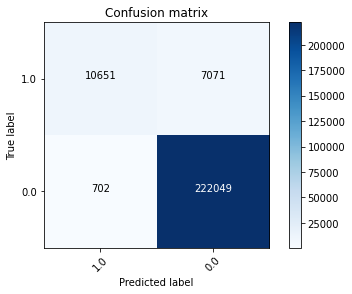

In [16]:
y_true = pred.select("label")
y_true = y_true.toPandas()

y_pred = pred.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [17]:
accuracy = pred.filter(pred.label == pred.prediction).count() / float(pred.count())
print("Accuracy : ",accuracy)

Accuracy :  0.9676762048130143


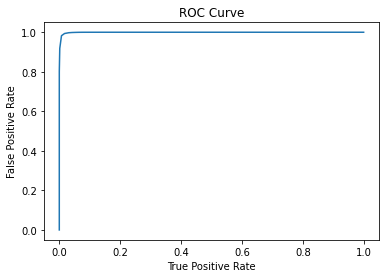

Training Area Under ROC: 0.9992725484327043


In [18]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training Area Under ROC: ' + str(trainingSummary.areaUnderROC))

In [19]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(pred))

Test Area Under ROC 0.9831225632294898


In [20]:
#Model 1 80-20 split
#Accuracy :  0.9676762048130143
#Training Area Under ROC: 0.9992808974017898   
#Test Area Under ROC 0.9831225938810771

In [21]:
lr2 = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=3)
lrModel2 = lr2.fit(train2)
pred2 = lrModel2.transform(test2)

Confusion matrix, without normalization
[[ 13317   8905]
 [   886 277799]]


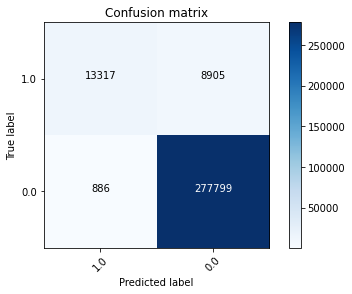

In [22]:
y_true2 = pred2.select("label")
y_true2 = y_true2.toPandas()

y_pred2 = pred2.select("prediction")
y_pred2 = y_pred2.toPandas()

cnf_matrix2 = confusion_matrix(y_true2, y_pred2,labels=class_names)

plt.figure()
plot_confusion_matrix(cnf_matrix2, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [23]:
accuracy2 = pred2.filter(pred2.label == pred2.prediction).count() / float(pred2.count())
print("Accuracy : ",accuracy2)

Accuracy :  0.9674617074378462


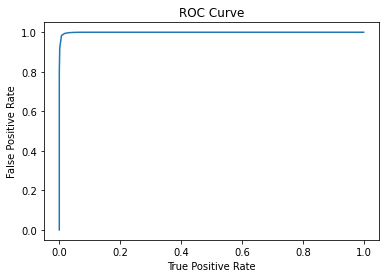

Training Area Under ROC: 0.9993034217833708


In [24]:
trainingSummary2 = lrModel2.summary
roc2 = trainingSummary2.roc.toPandas()
plt.plot(roc2['FPR'],roc2['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training Area Under ROC: ' + str(trainingSummary2.areaUnderROC))

In [25]:
print('Test Area Under ROC', evaluator.evaluate(pred2))

Test Area Under ROC 0.9828220494379982


In [26]:
#Model 2 75-25 split
#Accuracy :  0.9674617074378462
#Training Area Under ROC: 0.9993084178588645
#Test Area Under ROC 0.982823692357705

In [27]:
lr3 = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=3)
lrModel3 = lr3.fit(train3)
pred3 = lrModel3.transform(test3)

Confusion matrix, without normalization
[[ 15835  10725]
 [  1060 333843]]


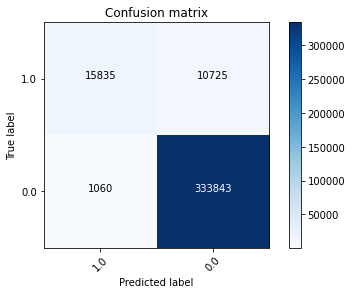

In [28]:
y_true3 = pred3.select("label")
y_true3 = y_true3.toPandas()

y_pred3 = pred3.select("prediction")
y_pred3 = y_pred3.toPandas()

cnf_matrix3 = confusion_matrix(y_true3, y_pred3,labels=class_names)

plt.figure()
plot_confusion_matrix(cnf_matrix3, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [29]:
accuracy3 = pred3.filter(pred3.label == pred3.prediction).count() / float(pred3.count())
print("Accuracy : ",accuracy3)

Accuracy :  0.9673963863521301


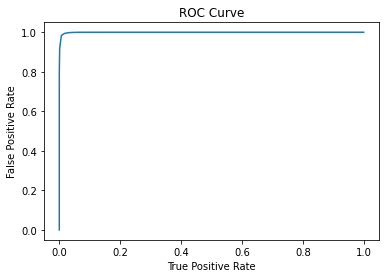

Training Area Under ROC: 0.9993393714158192


In [30]:
trainingSummary3 = lrModel3.summary
roc3 = trainingSummary3.roc.toPandas()
plt.plot(roc3['FPR'],roc3['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training Area Under ROC: ' + str(trainingSummary3.areaUnderROC))

In [31]:
print('Test Area Under ROC', evaluator.evaluate(pred3))

Test Area Under ROC 0.982175510914435


In [32]:
#Model 3 70-30 split
#Accuracy :  0.9673963863521301
#Training Area Under ROC: 0.9993391035377046
#Test Area Under ROC 0.9821757322179495

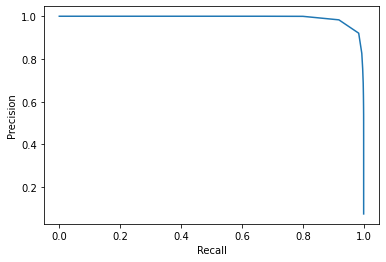

In [33]:
pr3 = trainingSummary3.pr.toPandas()
plt.plot(pr3['recall'],pr3['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()